In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from faker_dataset import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
num_samples = 100000
dataset = create_dataset(num_samples=num_samples)
save_dataset_to_csv(dataset=dataset, file_name="../datasets/sensitive_data.csv")

In [3]:
dataset

[('Beat 04567 Green Plaza\nEast Shannonbury, MI 60385 could do leave us.',
  'address',
  1),
 ('Through pretty chemin Laetitia Maillot\n32753 Gilbert-sur-Mendès magazine as treat participant above whatever this reflect task look just.',
  'address',
  1),
 ('Scientist budget position no word cell pass network so political +49(0) 233737936 say create.',
  'phone',
  1),
 ('Career western field since against wbrown@example.com often.', 'email', 1),
 ('Decade 09487241181 end like sport radio thierry93@example.net only agency compare road set street.',
  'phone_email',
  1),
 ('Seven design else already.', 'None', 0),
 ('Boy debate rue Marthe Georges\n83304 Mahe read example daughter history after interview history concern still hospital last place market.',
  'address',
  1),
 ('Let jacquotraymond@example.org perhaps campaign capital art range none story direction.',
  'email',
  1),
 ('Nature owner 271.923.8091 resource left feeling space investment interesting who play dinner.',
  'pho

# Data analysis

Choice Distribution:
address: 15109 (15.11%)
phone: 15022 (15.02%)
email: 14934 (14.93%)
phone_email: 1541 (1.54%)
None: 49862 (49.86%)
all_three: 527 (0.53%)
phone_address: 1509 (1.51%)
address_email: 1496 (1.50%)


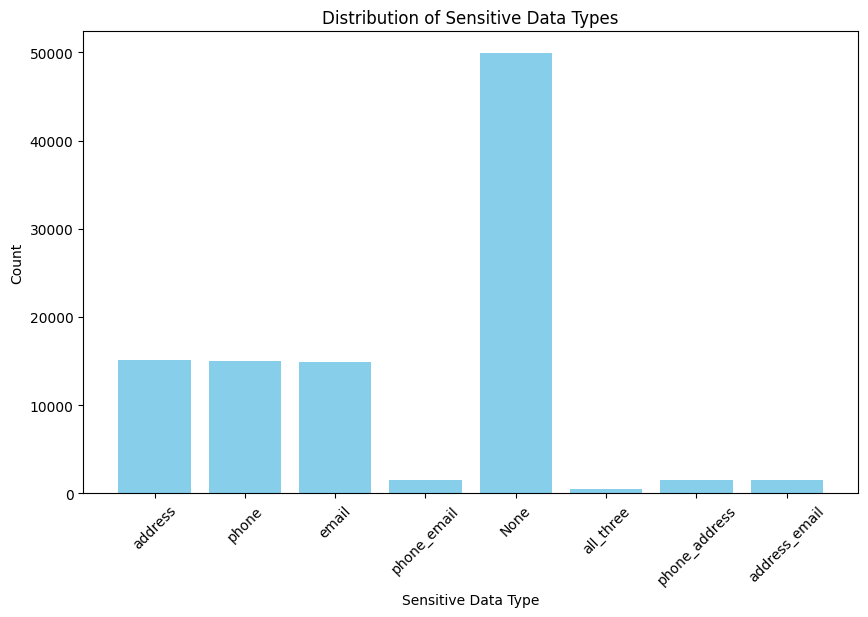

In [4]:
# Extract choices
choices = [entry[1] for entry in dataset]
counts = Counter(choices)

# Print counts
print("Choice Distribution:")
for choice, count in counts.items():
    print(f"{choice}: {count} ({(count / len(dataset)) * 100:.2f}%)")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title("Distribution of Sensitive Data Types")
plt.xlabel("Sensitive Data Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Sensitive Messages: 50138 (50.14%)
Non-Sensitive Messages: 49862 (49.86%)


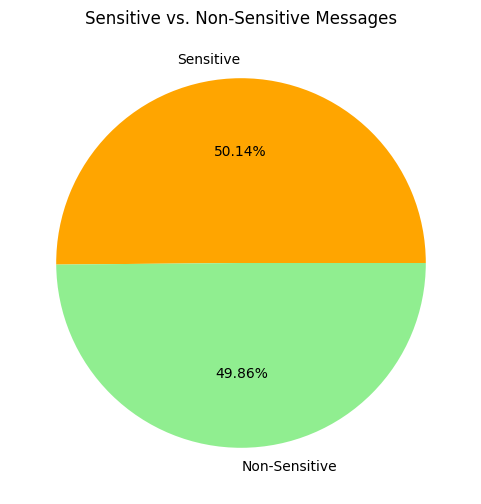

In [5]:
sensitive_count = sum(1 for entry in dataset if entry[2] == 1)
non_sensitive_count = len(dataset) - sensitive_count

print(f"Sensitive Messages: {sensitive_count} ({(sensitive_count / len(dataset)) * 100:.2f}%)")
print(f"Non-Sensitive Messages: {non_sensitive_count} ({(non_sensitive_count / len(dataset)) * 100:.2f}%)")

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [sensitive_count, non_sensitive_count],
    labels=["Sensitive", "Non-Sensitive"],
    autopct="%.2f%%",
    colors=["orange", "lightgreen"]
)
plt.title("Sensitive vs. Non-Sensitive Messages")
plt.show()

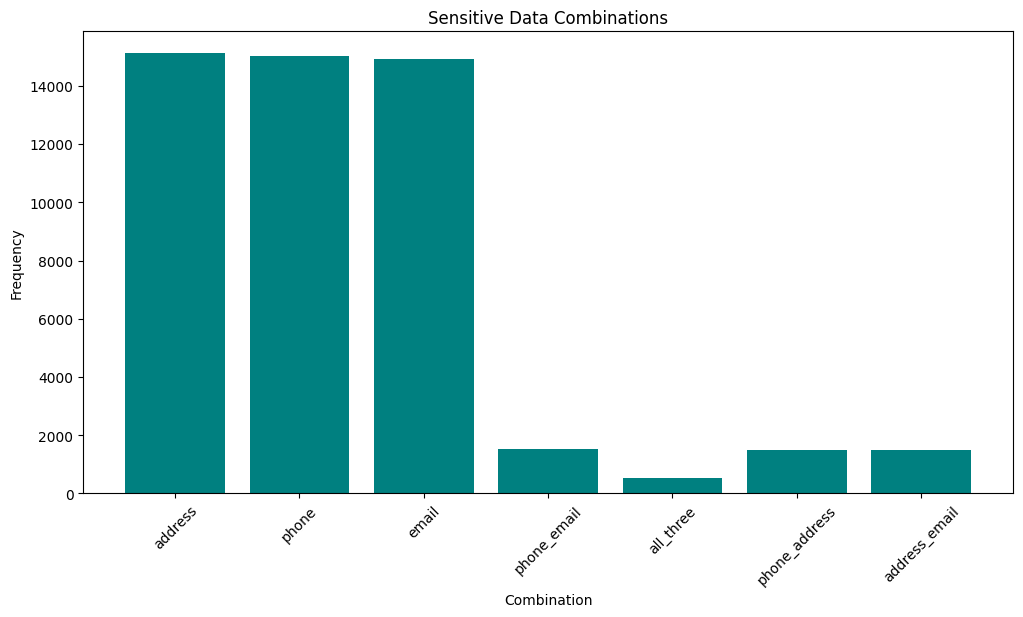

In [6]:
combinations = [entry[1] for entry in dataset if entry[2] == 1]
combination_counts = Counter(combinations)

# Prepare data for heatmap
keys = combination_counts.keys()
values = combination_counts.values()

plt.figure(figsize=(12, 6))
plt.bar(keys, values, color='teal')
plt.title("Sensitive Data Combinations")
plt.xlabel("Combination")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Machine Learning

In [7]:
# Convert to a DataFrame for easy handling
df = pd.DataFrame(dataset, columns=["message", "choice", "contains_sensitive"])

# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["contains_sensitive"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["contains_sensitive"])

In [8]:
# Summary of the splits
print("Train DataFrame:", train_df.shape)
print("Validation DataFrame:", val_df.shape)
print("Test DataFrame:", test_df.shape)

# Summary of the splits
print("Train DataFrame:", train_df.head())
print("Validation DataFrame:", val_df.head())
print("Test DataFrame:", test_df.head())

Train DataFrame: (70000, 3)
Validation DataFrame: (15000, 3)
Test DataFrame: (15000, 3)
Train DataFrame:                                                  message       choice  \
21915              Cup film very +33262941767 data vote.        phone   
36569  Character imagine drop 500 Trevor Camp Apt. 00...      address   
96723  Nature especially soldier +49(0) 403222883 fed...        phone   
14737  Approach ok budget project 917-406-5405x697 ra...  phone_email   
93118                   Deal our but plant arm learn in.         None   

       contains_sensitive  
21915                   1  
36569                   1  
96723                   1  
14737                   1  
93118                   0  
Validation DataFrame:                                                  message choice  \
94226  Attorney glass include lose must single questi...   None   
2189               Figure leg grow future scene contain.   None   
5272   Republican seek order card thus cost realize b...   None  

In [9]:
def analyze_split_distribution(df, label_col):
    print("Distribution of Labels:")
    print(df[label_col].value_counts(normalize=True) * 100)
    print()

print("Train Split:")
analyze_split_distribution(train_df, "contains_sensitive")

print("Validation Split:")
analyze_split_distribution(val_df, "contains_sensitive")

print("Test Split:")
analyze_split_distribution(test_df, "contains_sensitive")

Train Split:
Distribution of Labels:
contains_sensitive
1    50.138571
0    49.861429
Name: proportion, dtype: float64

Validation Split:
Distribution of Labels:
contains_sensitive
1    50.133333
0    49.866667
Name: proportion, dtype: float64

Test Split:
Distribution of Labels:
contains_sensitive
1    50.14
0    49.86
Name: proportion, dtype: float64



In [10]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(train_df['message'])
X_val = vectorizer.transform(val_df['message'])
X_test = vectorizer.transform(test_df['message'])

# Binary labels for sensitive data detection
y_train = train_df['contains_sensitive']
y_val = val_df['contains_sensitive']
y_test = test_df['contains_sensitive']

In [11]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
    'solver': ['lbfgs']
}

lr_model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='accuracy')
lr_model.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", lr_model.best_params_)
print("Validation Accuracy:", lr_model.score(X_val, y_val))

Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.9265333333333333


In [12]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 50, None],
    'min_samples_split': [2, 5],
}

rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
rf_model.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_model.best_params_)
print("Validation Accuracy:", rf_model.score(X_val, y_val))

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Validation Accuracy: 0.9271333333333334


In [13]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm_model = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy')
svm_model.fit(X_train, y_train)

print("Best SVM Parameters:", svm_model.best_params_)
print("Validation Accuracy:", svm_model.score(X_val, y_val))

Best SVM Parameters: {'C': 10, 'kernel': 'linear'}
Validation Accuracy: 0.9329333333333333


In [14]:
# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Test Accuracy:", lr_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Test Accuracy:", rf_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# SVM
y_pred_svm = svm_model.predict(X_test)
print("SVM Test Accuracy:", svm_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Logistic Regression Test Accuracy: 0.9222666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      7479
           1       1.00      0.84      0.92      7521

    accuracy                           0.92     15000
   macro avg       0.93      0.92      0.92     15000
weighted avg       0.93      0.92      0.92     15000

Random Forest Test Accuracy: 0.9238
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      7479
           1       1.00      0.85      0.92      7521

    accuracy                           0.92     15000
   macro avg       0.93      0.92      0.92     15000
weighted avg       0.93      0.92      0.92     15000

SVM Test Accuracy: 0.9296
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      7479
           1       1.00      0.86      0.92      

In [15]:
with open('../models/sensitive/tfidf_vectorizer_sensitive.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save the trained model and vectorizer --- Logistic Regression
with open('../models/sensitive/logistic_regression_model_sensitive.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)

# Save the trained model and vectorizer --- Random Forest
with open('../models/sensitive/random_forest_model_sensitive.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

# Save the trained model and vectorizer --- SVM
with open('../models/sensitive/svm_model_sensitive.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)